In [1]:
import pandas as pd
import numpy as np
from typing import List, Union
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Создадим класс для работы с данными

In [2]:
class BostonHousing:

    """
    Класс для работы с датафреймом.
    Параметры:
    self.df  - датафрейм
    Методы:
    unique_count(self) - метод посчета уникальных данных в столбцах
    correlation_number(self) - метод для вычисления корреляционной матрицы по числовым столбцам.
    correlation_category(self) - метод для вычисления корреляционной матрицы по категорийным столбцам
    heatmap(self, first_col: str, second_col: str, main_col: str ) - метод построения графика корр. матрицы
    my_graf(self, first_col, second_col, data_df=None) - метод построения графиков
    remove_outliers_STD(self, numerical_columns) - метод для фильтрации выбросов (стандартное отклонение)
    remove_outliers_IQR(self, numerical_columns) - метод для фильтрации выбросов (квантили)
    """
    def __init__(self, path):
        self.df = pd.read_csv(path)

    def summary_statistics(self, first_col: str, second_col: str, **kwargs) -> pd.DataFrame:
       
        """
        Метод для вычисления статистики по second_col, сгруппированную по first_col.
        Параметры:
        first_col - первый столбец (используется для группировки)
        second_col - второй стобец - для посчета статистики
        **kwargs - словари для фильтрации (выполняются в первую очередь)
        Возвращает:
        pd.DataFrame - статистика по сгруппированным столбцам
        """
        
        df: pd.DataFrame = self.df  # Работаем с копией DataFrame
        
        # Применяем все фильтры, если они есть
        for filter_col, filter_value in kwargs.items():
            if filter_col == 'Cabin':
                # Фильтруем по первой букве в значении столбца 'Cabin'
                df = df[df[filter_col].str[0] == filter_value]
            else:
                # Фильтруем по обычному значению
                df = df[df[filter_col] == filter_value]
        
        # Возвращаем статистику по данным
        return df[[first_col, second_col]].groupby(first_col, observed=False).describe()

    def unique_count(self):
        
        """
        Метод посчета уникальных данных в столбцах и вывода их списком (если они не числа)
        """
    
        for col in self.df.columns:
            unique_count: int = self.df[col].nunique()  # Количество уникальных значений для каждого столбца
            unique_values: List[Union(int|str)] = self.df[col].unique().tolist()  # Список уникальных значений для каждого столбца
            
            # Проверяем, все ли значения можно преобразовать в числа (чтобы отсеять числовые поля)
            is_numeric: bool = pd.to_numeric(self.df[col], errors='coerce').notnull().all()
            
            if is_numeric:
                print(f"Столбец '{col}': уникальных значений {unique_count} — цифровые значения")
            else:
                print(f"Столбец '{col}': уникальных значений {unique_count} — {unique_values[:5]}")

    def correlation_number(self) -> pd.DataFrame:
        
        """
        Метод для вычисления корреляционной матрицы по числовым столбцам.
        Возвращает:
        correlation_matrix - корреляционную матрицу
        """
        
        columns_list: List[Union(int|float)]  = self.df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        correlation_matrix: pd.DataFrame = self.df[columns_list].corr()
        return correlation_matrix

    def correlation_category(self, *args) -> pd.DataFrame:
        
        """
        Метод для вычисления корреляционной матрицы по категорийным столбцам.
        Параметры
        *args - названия числовых столбов для добавления к этой матрице
        Возвращает:
        correlation_matrix - корреляционную матрицу
        """
        
        # Получаем все категориальные столбцы
        categorical_columns: List[str] = self.df.select_dtypes(include=['object', 'category']).columns.tolist()

        # Создаём копию данных, чтобы не изменять оригинальный DataFrame
        df_encoded: pd.DataFrame = self.df.copy()

        # Кодируем категориальные переменные в числовые
        label_encoder = LabelEncoder()
        for col in categorical_columns:
            df_encoded[col] = label_encoder.fit_transform(df_encoded[col])

        for item in args:
            categorical_columns.append(item)
    

        # Вычисляем корреляцию по закодированным данным
        correlation_matrix: pd.DataFrame = df_encoded[categorical_columns].corr()

        return correlation_matrix

    def heatmap(self, first_col: str = None, second_col: str = None, main_col: str = None, correlation: bool = False, pivot: bool = False, categorical: bool = False):
        """
        Универсальный метод построения графика корреляционной матрицы.
    
        Параметры:
        - first_col: str - столбец для оси X (обязательно, если correlation=False и pivot=False)
        - second_col: str - столбец для оси Y (обязательно, если correlation=False и pivot=False)
        - main_col: str - столбец, используемый для окраски (обязательно, если correlation=False и pivot=False)
        - correlation: bool - флаг, если True, строится корреляционная матрица.
        - pivot: bool - флаг, если True, используется `pivot_table` (first_col = index, second_col = columns).
        - categorical: bool - флаг, если True, вычисляется корреляция категориальных признаков.
        
        """
        plt.figure(figsize=(10, 6))
    
        if correlation:
            if categorical:
                # Кодируем категориальные признаки числовыми значениями
                df_encoded = self.df.copy()
                for col in df_encoded.select_dtypes(include=['object']).columns:
                    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))
                heatmap_data = df_encoded.corr()
                title = "Корреляционная матрица (категориальные признаки)"
            else:
                # Обычная корреляция для числовых данных
                heatmap_data = self.df.corr(numeric_only=True)
                title = "Корреляционная матрица (числовые признаки)"
        elif pivot:
            if not first_col or not second_col or not main_col:
                raise ValueError("Для pivot-таблицы необходимо указать first_col, second_col и main_col")
            heatmap_data = self.df.pivot_table(index=first_col, columns=second_col, values=main_col, aggfunc='mean')
            title = f'Тепловая карта по {first_col} и {second_col}'
        else:
            if not first_col or not second_col or not main_col:
                raise ValueError("Необходимо указать first_col, second_col и main_col для группировки")
            heatmap_data = self.df.groupby([first_col, second_col])[main_col].mean().unstack(fill_value=0)
            title = f'Тепловая карта для {first_col} и {second_col}'
    
        sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'Значение'})
        plt.title(title)
        plt.xlabel(second_col if second_col else "")
        plt.ylabel(first_col if first_col else "")
    
        plt.show()


    def remove_outliers_STD(self, numerical_columns: List)-> pd.DataFrame:

        """
        Метод удаления выбросов с использованием стандартного отклонения.
    
        Параметры:
        - numerical_columns: List - список столбцов для фильтрации
        Возвращает:
        df - > pd.DataFrame - датафрейм
        """

        df: pd.DataFrame = self.df.copy()
        
        for col in numerical_columns:
            mean = df[col].mean()  # вычисляем среднее
            std = df[col].std()  # вычисляем стандартное отклонение
            threshold_upper = mean + 3 * std  # верхняя граница
            threshold_lower = mean - 3 * std  # нижняя граница
            df = df[(self.df[col] >= threshold_lower) & (df[col] <= threshold_upper)]  # удаляем выбросы
        return df


    def remove_outliers_IQR(self, numerical_columns: List)-> pd.DataFrame:

        """
        Метод удаления выбросов с использованием IQR
    
        Параметры:
        - numerical_columns: List - список столбцов для фильтрации
        Возвращает:
        df - > pd.DataFrame - датафрейм
        """

        df: pd.DataFrame = self.df.copy()
        
        for col in numerical_columns:
            Q1 = df[col].quantile(0.25)  # первый квартиль
            Q3 = df[col].quantile(0.75)  # третий квартиль
            IQR = Q3 - Q1  # межквартильный размах
            lower_bound = Q1 - 1.5 * IQR  # нижняя граница для выбросов
            upper_bound = Q3 + 1.5 * IQR  # верхняя граница для выбросов
            df = df[(self.df[col] >= lower_bound) & (df[col] <= upper_bound)]  # удаляем выбросы
        return df

    def my_graf(self, first_col: str, second_col: str, data_df: pd.DataFrame = None):

        """
        Метод построения графиков
    
        Параметры:
        - first_col: str - первый столбец для графика
        - second_col: str - второй столбец для графика
        - data_df = None - датафрейм (передается для отсеянных данных)

        """

        
        if data_df is None:
            data_df = self.df  # Используем self.df, если датафрейм не передан
        
        plt.figure(figsize=(10, 5))
        sns.boxplot(data=data_df, x=first_col, y=second_col, hue=first_col, palette='coolwarm', dodge=False)
        
        plt.title(f'{first_col} в зависимости от {second_col}')
        plt.xlabel(first_col)
        plt.ylabel(second_col)
        
        plt.xticks(rotation=45)  # Поворот подписей, если категории длинные
        plt.show()



# Проверим основные данные и построим корреляционную матрицу

In [3]:
house = BostonHousing('content/BostonHousing.csv')

In [4]:
house.df

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [5]:
house.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


Описание сета
- CRIM — уровень преступности на душу населения по городам
- ZN — доля жилых земель, отведенных под участки площадью более 25 000 кв. футов
- INDUS — доля неторговых акров в городе.
- CHAS — фиктивная переменная реки Чарльз (1, если участок граничит с рекой; 0 в противном случае)
- NOX — концентрация оксидов азота (частей на 10 миллионов)
- RM — среднее количество комнат на жилище
- AGE — доля домов, занимаемых владельцами, построенных до 1940 года
- DIS — взвешенные расстояния до пяти центров занятости Бостона
- RAD — индекс доступности радиальных автомагистралей
- TAX — ставка налога на имущество на полную стоимость за 10 000 долларов США
- PTRATIO — соотношение учеников и учителей по городам
- B — 1000(Bk — 0,63)^2, где Bk — доля чернокожих по городам
- LSTAT — % населения с более низким статусом
- MEDV — медианная стоимость домов, занимаемых владельцами, в тысячах долларов США

Так как все данные цифровые построим кореляционную матрицу

In [6]:
house.correlation_number()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
crim,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
zn,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
indus,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
chas,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
nox,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
rm,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
age,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
dis,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
rad,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
tax,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


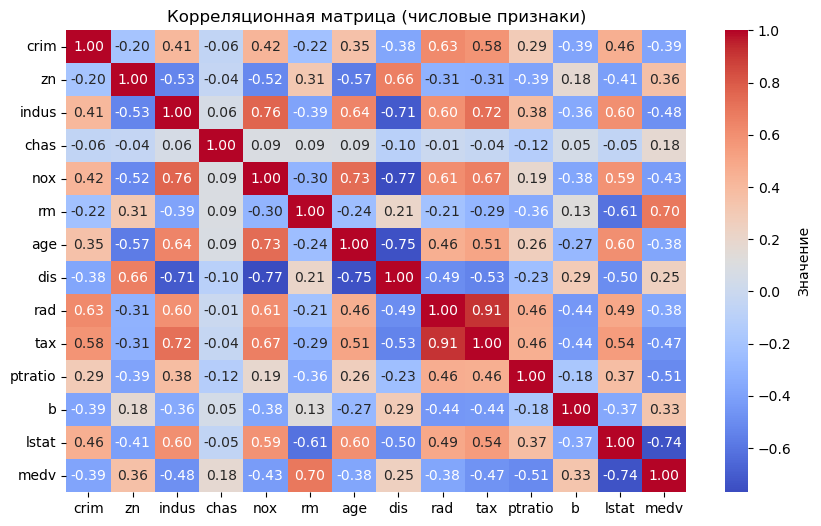

In [7]:
house.heatmap(correlation=True)

Нас в большей степени интересуют зависимости связанные с столбцом MEDV (стоимостью домов). ПО корреляционной матрице мы видим довольно высокую корреляцию по большиству столбцов за исключением столбца CHAS(т.е наличие реки рядом маловлияет на какие либо другие данные).


# Проверка зависимостей medv от различный данных

## Распределение medv

In [8]:
house.df['medv'].describe()

count    506.000000
mean      22.532806
std        9.197104
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
Name: medv, dtype: float64

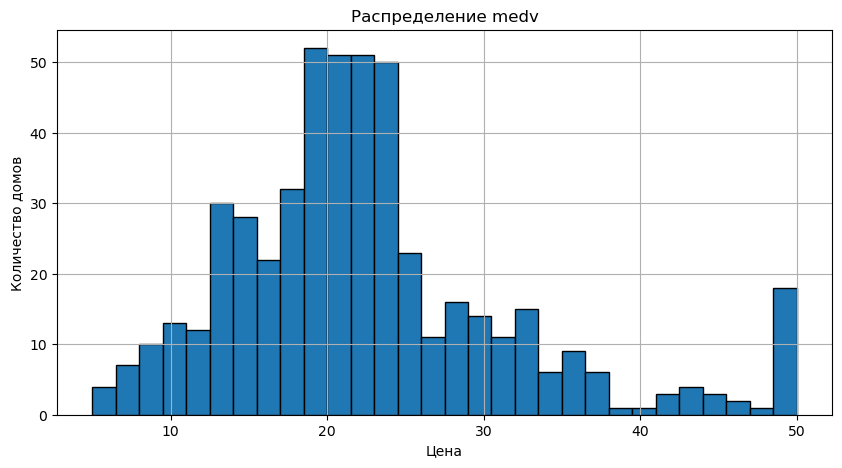

In [9]:
house.df['medv'].hist(bins=30, edgecolor='black',figsize=(10, 5))
plt.title('Распределение medv')
plt.xlabel('Цена')
plt.ylabel('Количество домов')
plt.show() 

Гистограмма показывает, что ряд основной пик домов с медианной ценой в пределах 20-35 , а также пик в районе medv = 50. Т.к данные в районе  medv = 50 довольно много данные не яляются выбросом, а являются спецификой для этих данных

Проверим отдельно общее распределение (с группировав medv в интервалы) и для medv= 50

In [10]:
# Для удобства расчетов сделаем интервалы для medv
bins = range(0, 70, 10)  # Это создаст интервалы 1-10, 11-20, ..., 41-50
labels = [f'{i}-{i+9}' for i in bins[:-1]]  # Например: 1-10, 11-20 и т.д.


# Создаем новый столбец с метками для групп
house.df['medv_group'] = pd.cut(house.df['medv'], bins=bins, labels=labels, right=False)

house.df['medv_group'] = pd.Categorical(house.df['medv_group'], categories=labels, ordered=True)

# Для каждой группы считаем среднее значение lstat
grouped = house.df.groupby('medv_group', observed=False)['lstat'].mean().reset_index()


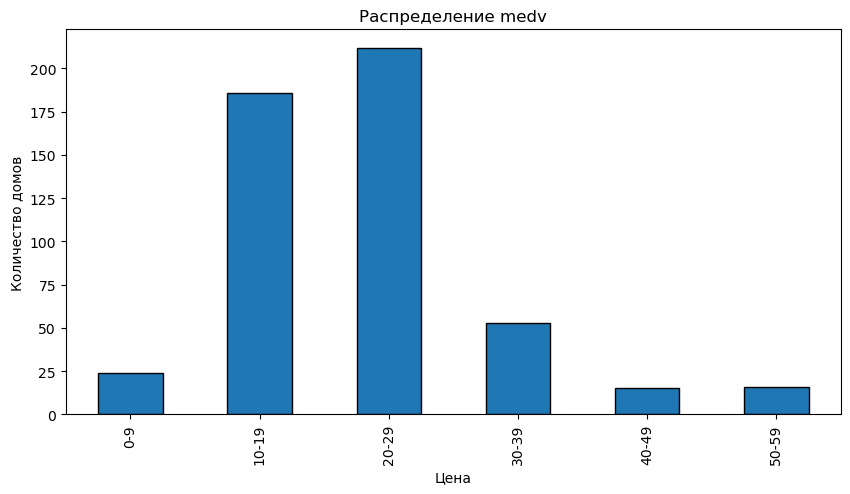

In [11]:
house.df['medv_group'].value_counts().sort_index().plot(kind='bar', edgecolor='black', figsize=(10, 5))
plt.title('Распределение medv')
plt.xlabel('Цена')
plt.ylabel('Количество домов')
plt.show() 

### Вывод: Разбивка на диапазоны подвердила, что основной пик домов с медианной ценой в пределах 20-35.

In [12]:
# Для оценки качества зданий medv == 50 получим данные для всего датафрейма

all_stats = house.df.describe()
all_stats


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [13]:
# И для medv == 50
houses_50 = house.df[house.df['medv'] == 50]
houses_50_stats = houses_50.describe()
houses_50_stats

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
count,16.000000,16.000000,16.000000,16.000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.00000,16.000000,16.000000,16.0
mean,2.703412,19.062500,11.860625,0.375,0.566569,7.484000,77.637500,2.586087,10.625000,415.437500,16.48125,381.743125,4.355000,50.0
std,3.145228,35.129226,8.187944,0.500,0.089586,1.062342,26.934609,1.592896,9.415413,188.201654,2.88056,12.920621,2.321221,0.0
min,0.013810,0.000000,0.460000,0.000,0.401000,4.970000,24.800000,1.129600,1.000000,193.000000,13.00000,347.880000,1.730000,50.0
25%,0.409203,0.000000,3.647500,0.000,0.500000,6.932750,63.650000,1.350650,4.750000,261.750000,14.62500,375.105000,2.967500,50.0
50%,1.491190,0.000000,18.100000,0.000,0.605000,7.853000,90.200000,2.043300,5.000000,403.000000,14.70000,386.495000,3.510000,50.0
75%,5.091160,20.000000,18.470000,1.000,0.631000,8.099750,96.975000,2.970600,24.000000,666.000000,20.20000,390.925000,4.752500,50.0
max,9.232300,95.000000,19.580000,1.000,0.668000,8.725000,100.000000,5.885000,24.000000,666.000000,20.20000,395.520000,9.530000,50.0


In [14]:
# построим результирующий детефрейм со стоими стобцами и рассчитаем процент отклонения

comparison = pd.DataFrame({
    'Среднее по данным': all_stats.loc['mean'],
    'Для домов с medv=50': houses_50_stats.loc['mean'],
    'Отличие в %': (abs(houses_50_stats.loc['mean'] - all_stats.loc['mean']) / all_stats.loc['mean']) * 100
})

# Исключаем строку 'medv' из comparison (если он есть)
comparison = comparison.drop('medv', axis=0, errors='ignore')

# Сортируем по отличию в процентах
comparison_sorted = comparison.sort_values('Отличие в %')
comparison_sorted

,Среднее по данным,Для домов с medv=50,Отличие в %
tax,408.237154,415.437500,1.763765
nox,0.554695,0.566569,2.140580
indus,11.136779,11.860625,6.499602
b,356.674032,381.743125,7.028573
ptratio,18.455534,16.481250,10.697516
rad,9.549407,10.625000,11.263452
age,68.574901,77.637500,13.215621
rm,6.284634,7.484000,19.084095
crim,3.613524,2.703412,25.186267
dis,3.795043,2.586087,31.856168


### Вывод: Принимая во внимание отличие свыше 15% мы получили, что осными факторами влияющими на довольно хорошую продаваемость домов с medv =50 следующие
- chas (близи реки)
Отличие составляет 442%. Это может указывать на то, что дома с медвальной ценой 50 гораздо чаще находятся вблизи реки, чем дома с другими ценами. Вывод интересный имеет смысл проверить дополнительно

- zn (доля жилых земель с участками более 25 000 кв. футов):
Отличие составляет 67.75%, что также довольно сильно. Это означает, что дома с medv=50 находятся на более просторных участках, чем другие дома. Это соответствует тому, что такие дома могут иметь большую площадь и поэтому более высокую цену.

- lstat (процент людей с низким статусом):
Отличие 65.58%. Это указывает на то, что дома с ценой 50 расположены в более благополучных районах, с меньшим процентом людей с низким статусом. Это может быть связано с тем, что дома с высокой ценой чаще находятся в более развитых и обеспеченных районах.

- dis (дистанция до центров трудовой активности):
Отличие 31.86%. Это также может означать, что дома с ценой 50 расположены ближе к центрам трудовой активности, что, в свою очередь, может также повлиять на цену этих домов, так как чаще всего это влияет на удобство/время дороги на работу.

- rm (среднее количество комнат):
Отличие 19.08%. Это говорит о том, что дома с ценой 50 имеют большее количество комнат, что тоже объяснимо для более дорогих домов.

- crim (уровень преступности):
Отличие 25.19%. Этот параметр показывает, что дома с ценой 50 расположены в районах с меньшим уровнем преступности, что также может быть связано с более высокими ценами на недвижимость в безопасных районах.

## Зависимость medv и chas

In [15]:
house.summary_statistics('medv_group', 'chas')

chas                                             
            count      mean       std  min  25%  50%  75%  max
medv_group                                                    
0-9          24.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
10-19       186.0  0.037634  0.190824  0.0  0.0  0.0  0.0  1.0
20-29       212.0  0.080189  0.272228  0.0  0.0  0.0  0.0  1.0
30-39        53.0  0.075472  0.266679  0.0  0.0  0.0  0.0  1.0
40-49        15.0  0.066667  0.258199  0.0  0.0  0.0  0.0  1.0
50-59        16.0  0.375000  0.500000  0.0  0.0  0.0  1.0  1.0

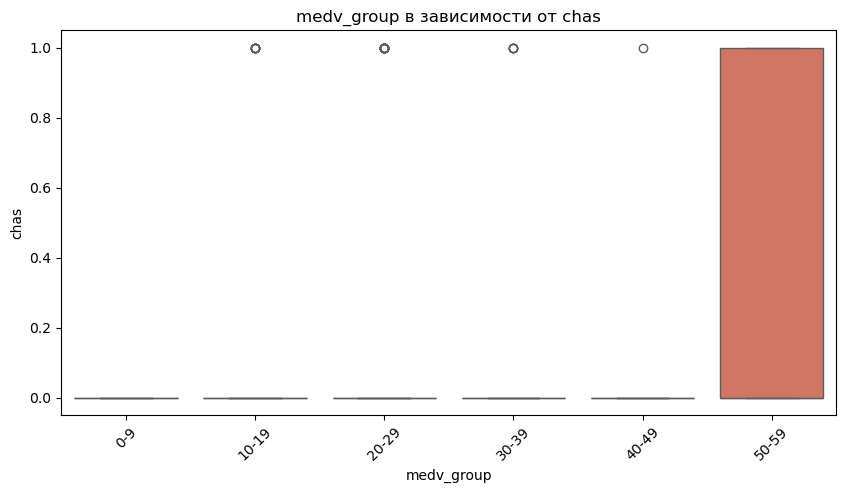

In [16]:
house.my_graf('medv_group','chas')

Судя по  полученным данным и графику зависимости , переменная chas (близость к реке Чарльз, где 1 — рядом, 0 — далеко) почти не влияет на распределение домов в более дешёвых категориях (medv_group < 50).
В группах 0-9, 10-19, 20-29, 30-39 и даже 40-49 доля домов рядом с рекой (chas = 1) практически нулевая (среднее значение около 0.07-0.08).
А вот в самой дорогой категории (50-59) среднее значение chas уже 0.375, что значительно выше. Это значит, что 37.5% дорогих домов расположены у реки.

In [17]:
# ПОлучим данные по наличию рядом реки у дорогих домов
house.df[house.df['medv_group'] == '50-59']['chas'].value_counts()


chas
0    10
1     6
Name: count, dtype: int64

### Вывод:Близость к реке существенно влияет только на самые дорогие дома. В остальных диапазонах это влияние минимально, и большая часть недвижимости находится далеко от реки. Вероятнее всего большую часть переговой линии реки занимают дорогие дома

## Зависимость medv и lstat

Сразу выведем таблицу по сгруппированным данным

In [18]:
house.summary_statistics('medv_group', 'lstat')

lstat                                                            
            count       mean       std    min      25%    50%      75%    max
medv_group                                                                   
0-9          24.0  26.359583  4.912658  18.05  22.9200  26.12  30.1250  36.98
10-19       186.0  17.554140  5.747564   7.79  13.6650  16.92  20.4225  37.97
20-29       212.0   9.778585  3.891272   3.33   6.7450   9.40  12.0625  29.55
30-39        53.0   5.711321  2.279714   1.98   4.3200   5.04   6.6800  14.79
40-49        15.0   3.954000  1.216598   2.47   3.1350   3.76   4.0450   7.26
50-59        16.0   4.355000  2.321221   1.73   2.9675   3.51   4.7525   9.53

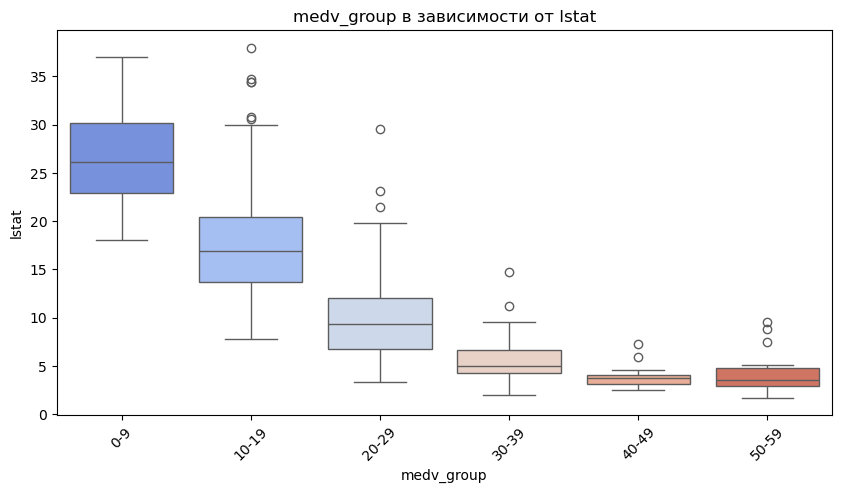

In [19]:
house.my_graf('medv_group','lstat')

Из графика видно, что имеются  данные вне основных "боксов". Это явные выбросы, т.к носят скорее единичный характер. 
Попробуем почистить данные от выбросов.


In [20]:
clean_house_irq = house.remove_outliers_IQR(['lstat'])

In [21]:
grouped_stats = clean_house_irq[['medv_group', 'lstat']].groupby('medv_group', observed=False).describe()
grouped_stats

lstat                                                             
            count       mean       std    min      25%     50%      75%    max
medv_group                                                                    
0-9          21.0  25.220952  4.029169  18.05  22.7400  25.680  29.0500  30.81
10-19       182.0  17.162363  5.151495   7.79  13.4900  16.695  20.0300  30.81
20-29       212.0   9.778585  3.891272   3.33   6.7450   9.400  12.0625  29.55
30-39        53.0   5.711321  2.279714   1.98   4.3200   5.040   6.6800  14.79
40-49        15.0   3.954000  1.216598   2.47   3.1350   3.760   4.0450   7.26
50-59        16.0   4.355000  2.321221   1.73   2.9675   3.510   4.7525   9.53

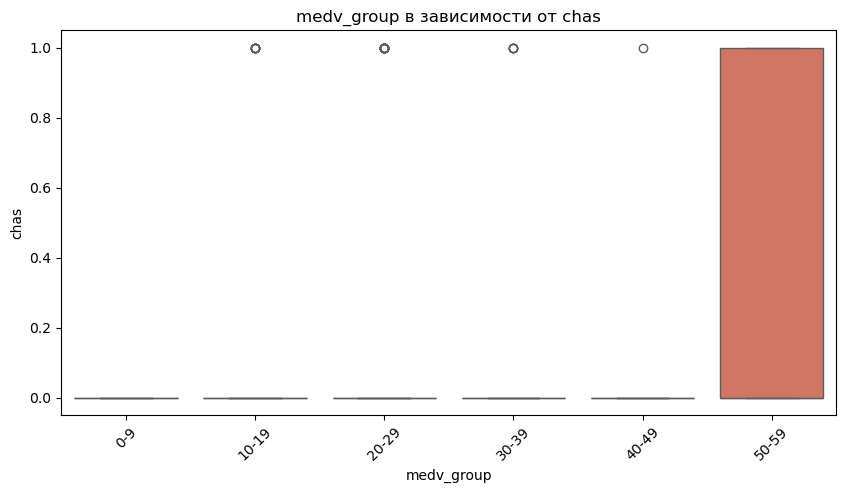

In [22]:
house.my_graf('medv_group','chas', clean_house_irq)

### Вывод: Из графика видно что медианная цена зависит от lstat. Чем меньше кол-во людей низкого статуса тем выше цена на дом. Зависмость гиперболическая.

## Зависимость medv_group от rm

In [23]:
house.summary_statistics('medv_group', 'rm')

rm                                                            
            count      mean       std    min      25%     50%      75%    max
medv_group                                                                   
0-9          24.0  5.728042  0.653510  4.368  5.33100  5.7995  6.19975  6.824
10-19       186.0  5.940113  0.487786  4.138  5.70525  5.9510  6.22750  7.393
20-29       212.0  6.250165  0.474317  3.561  6.00775  6.2435  6.51150  8.780
30-39        53.0  7.086491  0.350169  6.144  6.84200  7.1070  7.24900  8.069
40-49        15.0  7.821867  0.412712  6.943  7.56500  7.8200  8.25300  8.398
50-59        16.0  7.484000  1.062342  4.970  6.93275  7.8530  8.09975  8.725

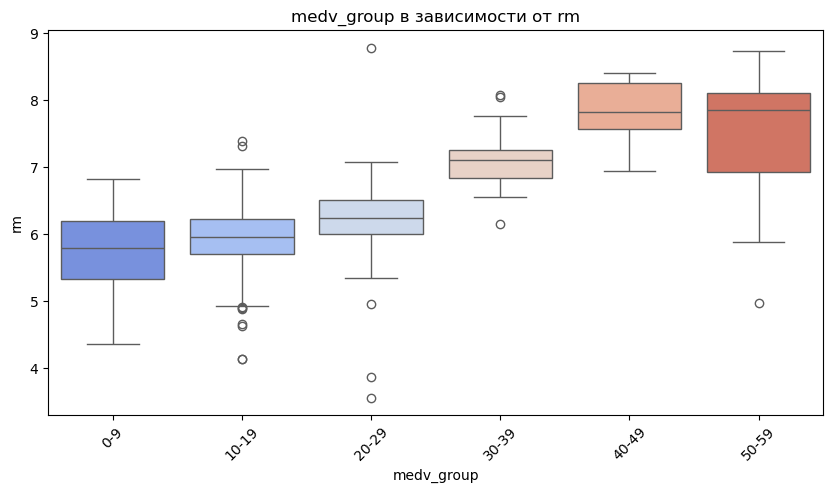

In [24]:
house.my_graf('medv_group','rm')

Из графика видно, что имеются  данные вне основных "боксов". Это явные выбросы, т.к носят скорее единичный характер. 
Попробуем почистить данные от выбросов.


In [25]:
clean_room_house_irq = house.remove_outliers_IQR(['rm'])
room_stats = clean_room_house_irq[['medv_group', 'rm']].groupby('medv_group', observed=False).describe()
room_stats

rm                                                            
            count      mean       std    min      25%     50%      75%    max
medv_group                                                                   
0-9          22.0  5.844818  0.543851  5.000  5.42375  5.8740  6.29525  6.824
10-19       182.0  5.974203  0.432967  4.880  5.71000  5.9640  6.22900  7.393
20-29       209.0  6.262349  0.367611  4.963  6.01200  6.2450  6.51100  7.079
30-39        50.0  7.034200  0.282285  6.144  6.83000  7.0960  7.22850  7.691
40-49         7.0  7.475429  0.250719  6.943  7.46200  7.5200  7.62750  7.686
50-59         6.0  6.374833  0.893985  4.970  5.96025  6.4495  6.93275  7.489

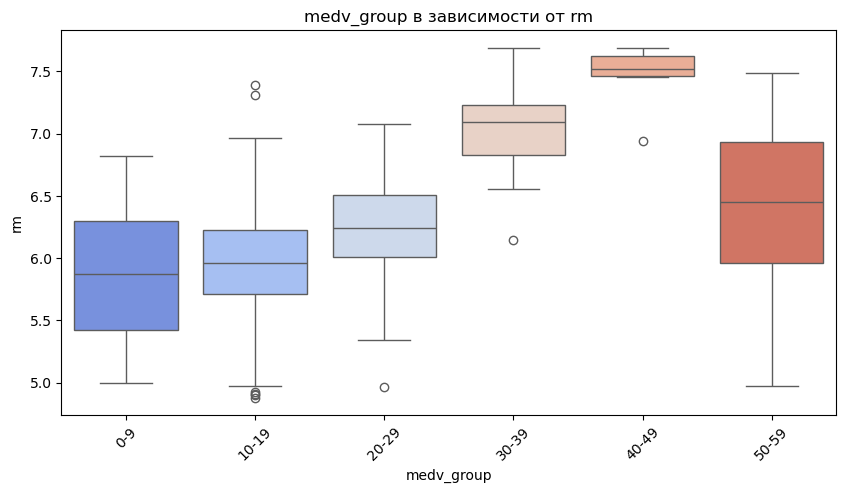

In [26]:
house.my_graf('medv_group','rm',clean_room_house_irq)

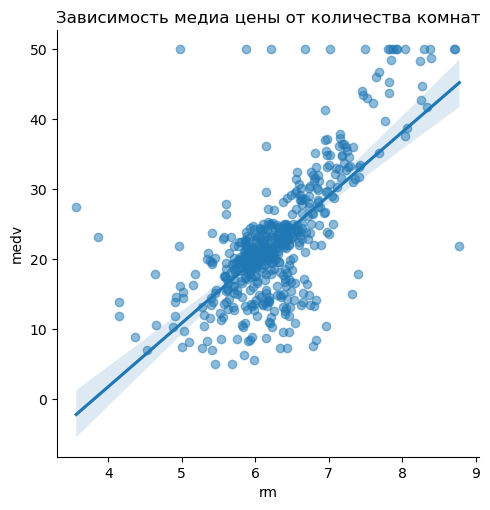

In [27]:
sns.lmplot(data=house.df, x="rm", y="medv", scatter_kws={"alpha":0.5} )
plt.title("Зависимость медиа цены от количества комнат")
plt.show()

### Вывод: Количество комнат влияет на цену до определённого уровня (medv ≈ 40k), но дальше оно уже не является ключевым фактором. У самых дорогих домов (medv = 50k) среднее количество комнат даже чуть меньше, чем в 40-49k. Это скорее всего говорит о том, что с определнного уровня домов начинает играть качество самого дома и его расположение, а кол-во копмна

## Зависимость medv_group от ptratio

In [28]:
house.summary_statistics('medv_group', 'ptratio')

ptratio                                                     
             count       mean       std   min     25%   50%   75%   max
medv_group                                                             
0-9           24.0  20.191667  0.028233  20.1  20.200  20.2  20.2  20.2
10-19        186.0  19.394086  1.920928  14.7  18.950  20.2  20.2  22.0
20-29        212.0  18.287264  1.772106  13.0  16.800  18.6  19.6  22.0
30-39         53.0  16.424528  1.988032  12.6  15.200  17.4  17.8  19.2
40-49         15.0  15.700000  1.974842  13.0  14.700  14.9  17.4  19.1
50-59         16.0  16.481250  2.880560  13.0  14.625  14.7  20.2  20.2

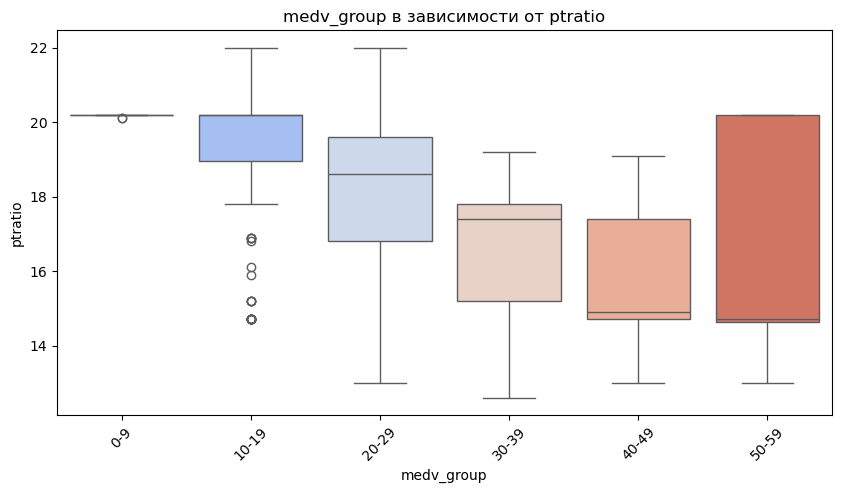

In [29]:
house.my_graf('medv_group','ptratio')

Из графика видно, что имеются  данные вне основных "боксов". Это явные выбросы, т.к носят скорее единичный характер. 
Попробуем почистить данные от выбросов.


In [30]:
clean_ptratio_house_irq = house.remove_outliers_IQR(['ptratio'])
ptratio_stats = clean_ptratio_house_irq[['medv_group', 'ptratio']].groupby('medv_group', observed=False).describe()
ptratio_stats

ptratio                                                        
             count       mean       std   min     25%    50%     75%   max
medv_group                                                                
0-9           24.0  20.191667  0.028233  20.1  20.200  20.20  20.200  20.2
10-19        186.0  19.394086  1.920928  14.7  18.950  20.20  20.200  22.0
20-29        211.0  18.312322  1.738264  14.7  16.850  18.60  19.600  22.0
30-39         44.0  17.152273  1.257256  14.9  15.975  17.60  17.925  19.2
40-49         12.0  16.375000  1.574296  14.7  14.850  16.65  17.400  19.1
50-59         14.0  16.978571  2.728251  13.6  14.700  16.05  20.200  20.2

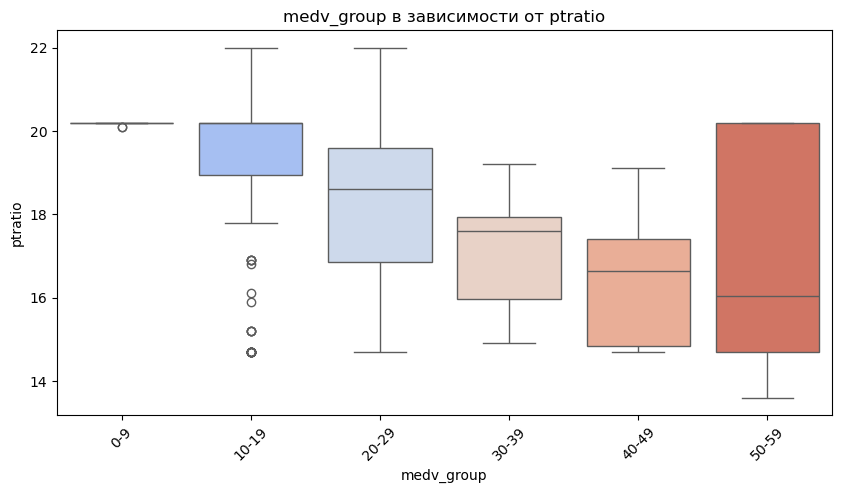

In [31]:
house.my_graf('medv_group','ptratio', clean_ptratio_house_irq)

- В дешёвых районах (medv_group = 0-9, 10-19) PTRATIO выше (~20), что говорит о школах с большим кол-вом учеников на 1 учителя (большими/общими классами)
- По мере роста цен на дома (medv_group = 20-39), PTRATIO падает (до 16-17), что характерно для более элитных районов
- Самые дорогие дома (medv_group = 50-59) показывают разброс (PTRATIO = 13.6 – 20.2). Из этого можно сделать 2 гипотезы
  Для высокого значения параметра PTRATIO:
  -1. Дорогие дома, согласно найденной ранее закономерностью находтся ближе к центрами занятости. А для таких районов более характерны общие классы. 
  -2. Дорогие дома могут находиться и в дешевых районах с общими школами
  Для низкого значения параметра PTRATIO:
  - Сохраняется и общая тенденция -  более индивидуальных классов в более элитном районе.

### Вывод: Из полученных данных и графика видно что чем качественные школы находятся в районах со средней и высокой стоимостью жилья, но самые дорогие дома могут располагаться в местах, где школьный фактор не играет главную роль

## Зависимость medv_group от INDUS

In [32]:
house.summary_statistics('medv_group', 'indus')

indus                                                          
            count       mean       std    min      25%    50%    75%    max
medv_group                                                                 
0-9          24.0  18.903333  2.721660  18.10  18.1000  18.10  18.10  27.74
10-19       186.0  14.542849  6.128189   1.69   8.1400  18.10  18.10  27.74
20-29       212.0   9.498585  5.988318   0.74   4.9300   7.38  13.89  27.74
30-39        53.0   3.640189  1.789226   1.22   2.1800   3.33   4.95   7.07
40-49        15.0   5.344000  4.194208   2.03   3.3300   3.97   6.20  19.58
50-59        16.0  11.860625  8.187944   0.46   3.6475  18.10  18.47  19.58

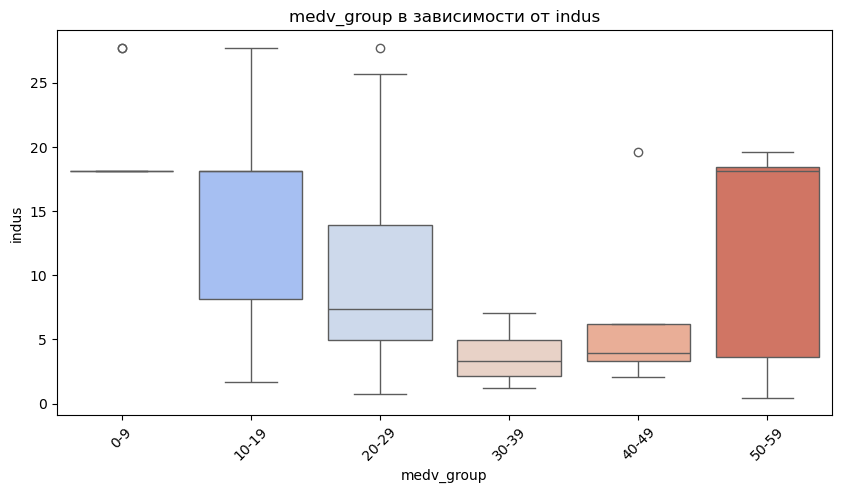

In [33]:
house.my_graf('medv_group','indus')

Выбросов почти нет поэтому можно их не чистить

### Вывод:
- Максимальные значения indus для группы 0-9 (низкие цены, высокое значение индустриализации):
Эти дома находятся в максимально индустриализированных районах, что может означать наличие фабрик, складов, производственных объектов и других промышленных зон. Такие районы менее привлекательны для проживания, но могут быть более выгодными для бизнеса, что делает эти дома дешевыми.
Гипотеза: для более дешевых домов индустриализация более выражена, так как они находятся в местах с высоким уровнем промышленности и низкой стоимостью земли.

- Падение индустриализации с ростом цен на дома (группы 10-19, 20-29, 30-39):
Это подтверждает, что с ростом цен дома расположены в более жилых и уютных районах, где промышленность уже не так сильно выражена, а больше зеленых зон, учебных учреждений и жилых домов.
Гипотеза: чем дороже район, тем меньше в нем промышленных объектов и больше жилых/коммерческих зон.

- Возвращение высоких значений indus в группе 50-59 (дорогие дома, высокая индустриализация):

В этих районах могут быть дорогие дома в промышленных или старых районах, но на фоне более дорогой недвижимости.
Два возможных объяснения:
- Гипотеза 1: Дома находятся в близи центров занятости (что мы уже находили в исследовании(, где высокие значения индустриализации (например, в районах с офисными зданиями, технологическими центрами, вблизи крупных бизнес-районов). Такие районы могут быть дорогими например для жителей работающих в крутом бизнес-секторе.
- Гипотеза 2: Эти районы могут быть старым промышленным районом, который преобразуется, но всё ещё сохраняет высокий уровень индустриализации. Возможно, это первоначально дешевое жилье, которое со временем перестроили в дорогое

## Зависимость medv_group от age

In [34]:
house.summary_statistics('medv_group', 'age')

age                                                          
            count       mean        std   min    25%    50%      75%    max
medv_group                                                                 
0-9          24.0  94.570833   6.889468  76.5  91.10  97.50  100.000  100.0
10-19       186.0  85.277419  18.860155  18.5  82.15  93.55   97.625  100.0
20-29       212.0  55.752830  26.623039   2.9  33.45  56.25   78.975  100.0
30-39        53.0  50.816981  26.590533   9.9  28.10  42.80   76.000  100.0
40-49        15.0  54.166667  29.200701   8.4  33.70  52.60   75.800   97.4
50-59        16.0  77.637500  26.934609  24.8  63.65  90.20   96.975  100.0

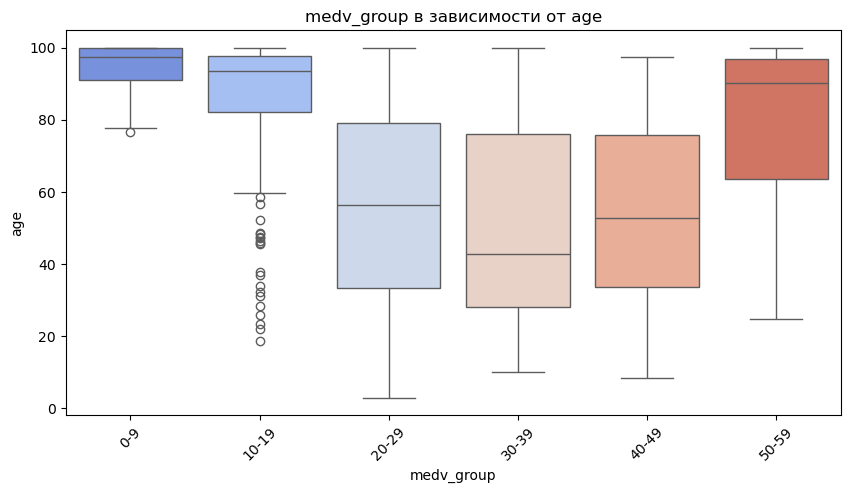

In [35]:
house.my_graf('medv_group','age')

### Вывод: Чем дом старее, тем дешевле (кроме очень дорогих домов):

- Для групп с меньшей медианной ценой (0-9, 10-19, 20-29) средний возраст домов самый высокий. Это указывает на то, что в более дешевых районах дома старее. Т.е цена вызванна тем что и дом старый, и возможно при застроке стоил меньше чем более поздние застройки.
Гипотеза: в более дешевых районах дома старые, так как земля дешевле и застройка была проведена в прошлом, когда стоимость жилья была ниже.

- В группах с более высокими ценами (40-49, 50-59) возраст домов значительно младше. Это соответствует тому, что новые дома или только что построенные или сданные в эксплуатацию здания находятся в более дорогих районах, где земля также стоит дороже.
Гипотеза: новые дома, как правило, строятся в развивающихся или престижных районах, которые еще не успели стареть и потому стоят дороже.

- Исключая самые дорогие дома:
В группе 50-59 (самые дорогие дома) видно, что возраст домов может быть разным: от достаточно старых до довольно новых. Это может означать, что самые дорогие дома не всегда новые, а могут быть в  престижных районах, где старые дома прошли перестройку, либо это  была специализированная застройка (например, элитные особняки в старых районах).
Гипотеза: дорогие дома в этой группе могут быть расположены в районах с классической застройкой, где не строят новые дома, но перестройка или реставрация старых зданий делает их более дорогими.


## Зависимость medv_group от tax

In [36]:
house.summary_statistics('medv_group', 'tax')

tax                                                            
            count        mean         std    min     25%    50%    75%    max
medv_group                                                                   
0-9          24.0  669.750000   12.704843  666.0  666.00  666.0  666.0  711.0
10-19       186.0  486.231183  166.610747  188.0  311.00  437.0  666.0  711.0
20-29       212.0  351.127358  134.633812  188.0  276.75  304.0  391.0  711.0
30-39        53.0  277.207547   63.368082  187.0  223.00  264.0  307.0  402.0
40-49        15.0  285.133333   52.223239  216.0  254.00  276.0  307.0  403.0
50-59        16.0  415.437500  188.201654  193.0  261.75  403.0  666.0  666.0

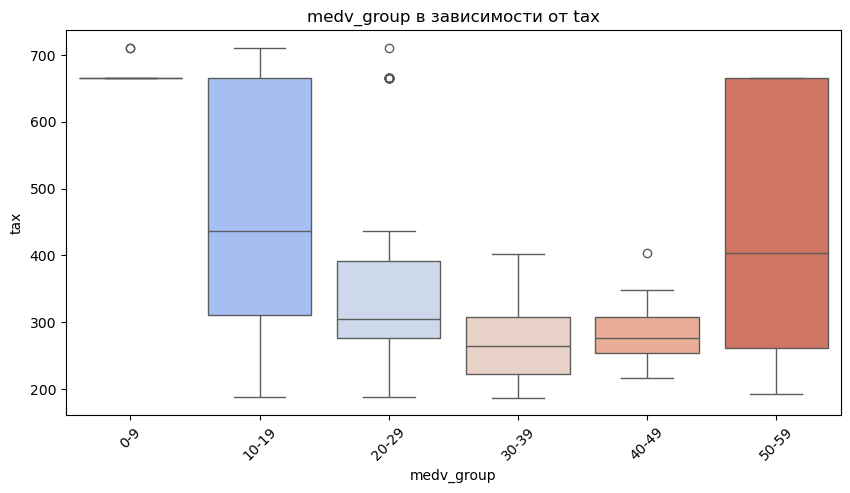

In [37]:
house.my_graf('medv_group', 'tax')

### Вывод: Чем дом дороже, тем ставка налога ниде (кроме очень дорогих домов):
- Для дешевых домов (medv_group 0-9) налоговая ставка постоянна и высокая.
Гипотеза:  исходя из данных полученных при изучении влиянии фактора indus можно выдвинуть гиппотезу что такую ставку вызывает высокий процент бизнес-объектов и индустриализация.
- Средние группы (10-19, 20-29) имеют более низкие налоговые ставки,
Гипотеза: налоговая ставка снижается по мере улучшения цен на дома, так как в этих районах могут быть более жилые и менее индустриализованные районы.
- Для самых дорогих домов (50-59) ставка разная.
  - Гипотеза: Низкая ставка скорее всего у домов в районах с минимальной индустриалзиацией
  - Гипотеза: Высокая ставка указывает на дома расположенных в индустриальных районах (как показали предыдущие исследования, такая закономерность у дорогих домов есть)
  - ГИпотеза: Различая вызванны особенностями инфраструктуры районов у дорогих домов

## Зависимость medv_group от nox

In [38]:
house.summary_statistics('medv_group', 'nox')

nox                                                         
            count      mean       std    min      25%    50%    75%    max
medv_group                                                                
0-9          24.0  0.691167  0.031249  0.609  0.67900  0.693  0.700  0.740
10-19       186.0  0.617171  0.115844  0.398  0.53800  0.601  0.700  0.871
20-29       212.0  0.508335  0.090977  0.385  0.43700  0.491  0.547  0.871
30-39        53.0  0.471300  0.071120  0.400  0.42800  0.447  0.488  0.647
40-49        15.0  0.498860  0.084425  0.394  0.43695  0.504  0.541  0.647
50-59        16.0  0.566569  0.089586  0.401  0.50000  0.605  0.631  0.668

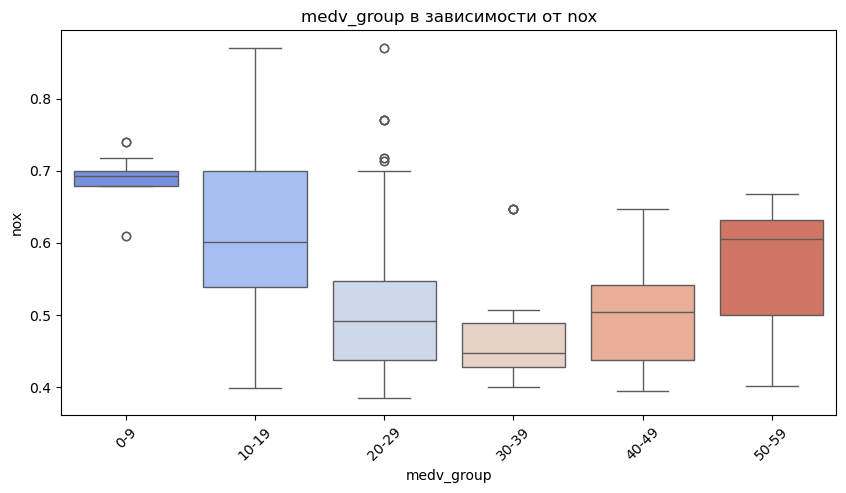

In [39]:
house.my_graf('medv_group', 'nox')

### Вывод. Исходя из данных и графика:
- 1. Загрязнение в промышленно-развивающихся районах (0-9)
В районе medv_group 0-9 (дешевые дома) наблюдается более высокая концентрация nox.
Гипотеза: Это может быть связано с тем, что такие районы часто расположены вблизи индустриальных объектов (это показали наши предыдушие исследования), дорог с интенсивным движением или производственных предприятий, где выхлопные газы и другие загрязняющие вещества в воздухе могут способствовать повышению концентрации оксида азота.
- 2. Уменьшение концентрации в менее индустриализированных районах (10-29)
В medv_group 10-29 концентрация nox начинает падать.
Гипотеза:Это может свидетельствовать о меньшей интенсивности промышленности и большем количестве жилых и зеленых зон. Такие районы могут быть менее загрязнены, потому что в них больше жилых домов и меньше производственных объектов. Это также может быть связано с более низким уровнем транспортной нагрузки и чистотой воздуха в таких зонах.
- 3. Повышение концентрации с ростом стоимости домов (40-59)
Для medv_group 40-59 концентрация nox снова увеличивается, что может указывать на :
Гипотеза: Возвращение к более индустриализированным зонам:Дорогие дома в этих районах находятся ближе к центрам занятости (установленно предыдущими исследованиями),крупным дорогам, бизнес-центрами/ заводами что увеличивает загрязнение от транспорта и предприятий.
Гипотеза:Элитная застройка вблизи крупных торговых и деловых центров: Иногда в дорогих районах могут строиться престижные застройки рядом с бизнес-центрами или даже с заводами, что тоже может повышать концентрацию загрязняющих веществ.


## Зависимость medv_group от crim

In [40]:
house.summary_statistics('medv_group', 'crim')

crim                                                       \
            count       mean        std      min        25%        50%   
medv_group                                                               
0-9          24.0  22.059312  18.779311  0.18337  11.391975  15.518750   
10-19       186.0   5.476324   9.510459  0.01360   0.228887   1.554570   
20-29       212.0   1.050858   2.540904  0.00632   0.060688   0.126145   
30-39        53.0   0.177886   0.227896  0.00906   0.033590   0.069110   
40-49        15.0   0.330583   0.325666  0.01538   0.048535   0.315330   
50-59        16.0   2.703412   3.145228  0.01381   0.409203   1.491190   

                                 
                  75%       max  
medv_group                       
0-9         24.862800  73.53410  
10-19        8.039962  88.97620  
20-29        0.360868  14.43830  
30-39        0.210380   0.82526  
40-49        0.527130   1.22358  
50-59        5.091160   9.23230

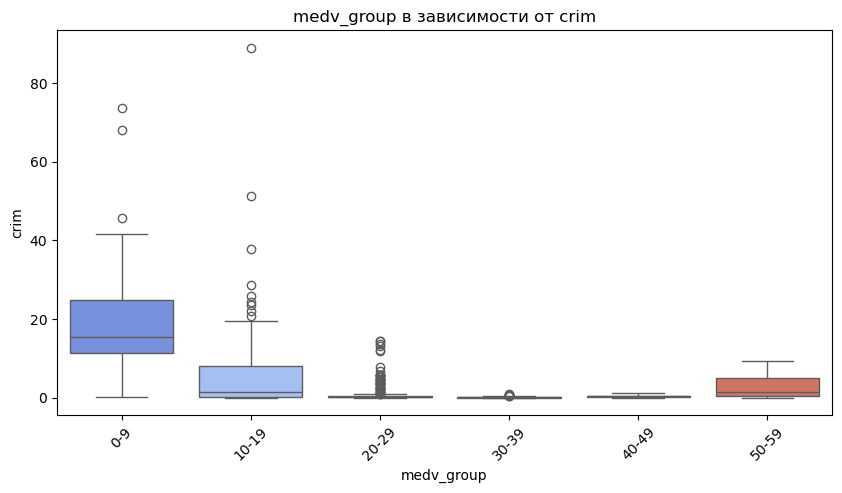

In [41]:
house.my_graf('medv_group', 'crim')

### Вывод. Исходя из данных и графика:
- Высокая преступность в дешевых районах (0-9)
В medv_group 0-9, где дома дешевые, уровень преступности (crim) значительно выше.
Гиппотеза: Это может свидетельствовать о наличии больших социальных проблем, таких как бедность, безработица, что также подтверждается исследованием зависимости lstat . Это характерно для менее обеспеченных и более неблагополучных районов, где преступность может быть выше.
- Снижение преступности с ростом стоимости домов (10-29)
В medv_group 10-29, где дома становятся дороже, уровень преступности значительно снижается.
Гиппотеза: Это может свидетельствовать о  том, что в более богатых районах более низкий уровень преступности. Здесь обычно лучше социальные условия (lstat), а также более развитые системы безопасности.
-  Небольшой рост преступности в дорогих районах (40-59)
В medv_group 40-59, где дома очень дорогие, наблюдается небольшой рост преступности по сравнению с предыдущими группами. Это может быть связано с:
Гиппотеза: Зона с более высокой коммерческой активностью и возможным большим количеством богатых людей, что может привлекать преступников.
Наличие дорогих объектов недвижимости и концентрация высокого уровня цен часто означает, что такие дома могут быть расположены вблизи культурных, деловых и коммерческих центров, что увеличивает риск преступлений (например, ограблений).Но уро безопасности в таких районах может быть выше поэтому рост не очень высокий

## Зависимость medv_group от RAD

In [42]:
house.summary_statistics('medv_group', 'rad')

rad                                                   
            count       mean       std  min    25%   50%   75%   max
medv_group                                                          
0-9          24.0  22.333333  5.646597  4.0  24.00  24.0  24.0  24.0
10-19       186.0  12.629032  9.738029  1.0   4.00   5.5  24.0  24.0
20-29       212.0   6.929245  6.721945  1.0   4.00   5.0   6.0  24.0
30-39        53.0   4.301887  1.957087  1.0   3.00   4.0   5.0   8.0
40-49        15.0   5.333333  2.093072  2.0   4.50   5.0   7.5   8.0
50-59        16.0  10.625000  9.415413  1.0   4.75   5.0  24.0  24.0

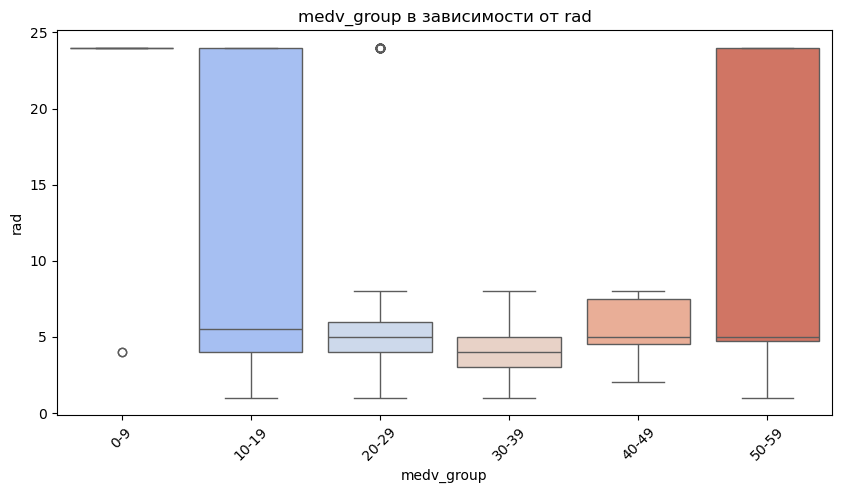

In [43]:
house.my_graf('medv_group', 'rad')

### Выводы: Исходя из данных и графика:
- 1. Мало магистралей в дешевых районах (0-9)
В medv_group 0-9, где дома дешевые, близость к магистралям максимальная .
Гиппотеза: Это может указывать на то, что такие дома расположены в глубине индустриальных районов которым связь автодорогоами жизненно необходима и также может означать большую концентрацию промышленности, где высокое загрязнение и другие факторы делают расположение жилья вблизи дорог менее желательным (что мы подтвердили предыдущими исследованиями).
- 2. Постепенное снижение близости к магистралям с ростом стоимости (10-29)
В medv_group 10-29 мы видим, что количество дорог рядом с домами постепенно снижается.
Гиппотеза: Это может свидетельствовать о том, что районы становятся менее индустриальными, а также более жилыми и комфортными для жизни. Здесь более высокий уровень жизни и меньшее количество промышленной активности, что снижает зависимость от магистралей.
- 3. Резкое падение близости к магистралям для спальных районов (30-49)
В medv_group 30-49 наблюдается резкое снижение близости к магистралям.
Гиппотеза: Это  спальные районы. В таких районах низкая коммерческая активность, а наличие магистралей рядом может быть воспринято как минус.
- 4. Возврат близости к магистралям в дорогих районах (50-59)
В medv_group 50-59, где дома очень дорогие, снова наблюдается увеличение близости к магистралям.
Гиппотеза:Это может быть связано с тем, что дорогие дома часто расположены вблизи центров занятости, где транспортное сообщение очень важно  для связи с другими частями города. 
Гиппотеза: такие районы могут находиться в исторических центрах или коммерческих зонах

## Зависимость medv_group от ZN

In [44]:
house.summary_statistics('medv_group', 'zn')

zn                                                   
            count       mean        std  min  25%   50%   75%    max
medv_group                                                          
0-9          24.0   0.000000   0.000000  0.0  0.0   0.0   0.0    0.0
10-19       186.0   3.051075  12.037950  0.0  0.0   0.0   0.0   80.0
20-29       212.0  12.384434  22.563015  0.0  0.0   0.0  21.0   85.0
30-39        53.0  35.141509  32.629679  0.0  0.0  33.0  55.0  100.0
40-49        15.0  25.966667  34.122922  0.0  0.0  20.0  21.0   95.0
50-59        16.0  19.062500  35.129226  0.0  0.0   0.0  20.0   95.0

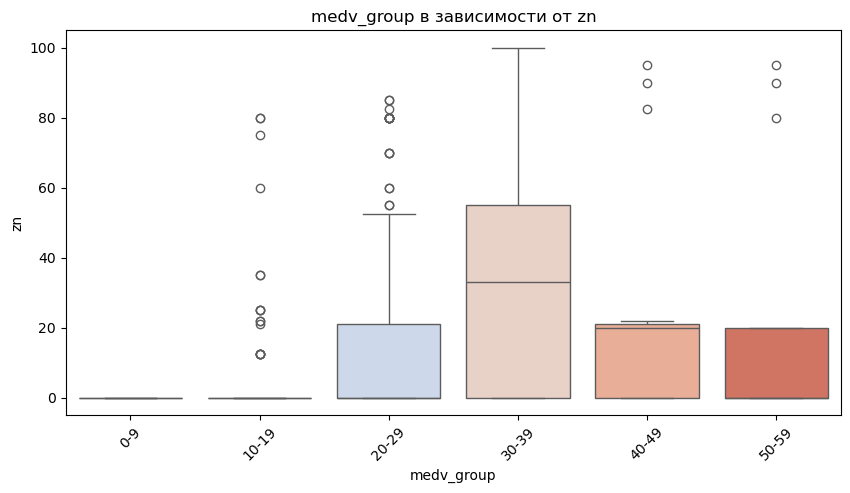

In [45]:
house.my_graf('medv_group', 'zn')

### Выводы: Исходя из данных и графика: До цены в 40 площадь территории увеличивается
- 1. Площадь территории для домов с ценой 0-19 минимальная, так как это напрямую влияет на цену дома
- 2. Начиная с 20 и до 40 площадь территории увеличивается и это влияет на цену дома.
  3. С 40 до 50 площадь территории падвает и почти не меняется это может быть вызванно:
     - Гиппотеза: площадь участка может быть уменьшена в пользу качественного дизайна
     - Гиппотеза: ограничение по площади из-за исторических мест города
     - Гиппотеза: маленькие но высокие/очень крутые


## Зависимость medv_group от b

In [46]:
house.summary_statistics('medv_group', 'b')

b                                                              \
            count        mean         std     min      25%      50%       75%   
medv_group                                                                      
0-9          24.0  231.185417  170.426445    7.68   43.210  323.945  396.9000   
10-19       186.0  328.586720  117.651690    0.32  336.200  388.300  396.2775   
20-29       212.0  382.957075   32.048513  131.42  383.550  393.150  396.4725   
30-39        53.0  391.150943    7.796457  354.31  389.710  393.420  396.9000   
40-49        15.0  385.712667    8.646826  363.43  382.000  386.860  391.5400   
50-59        16.0  381.743125   12.920621  347.88  375.105  386.495  390.9250   

                    
               max  
medv_group          
0-9         396.90  
10-19       396.90  
20-29       396.90  
30-39       396.90  
40-49       396.90  
50-59       395.52

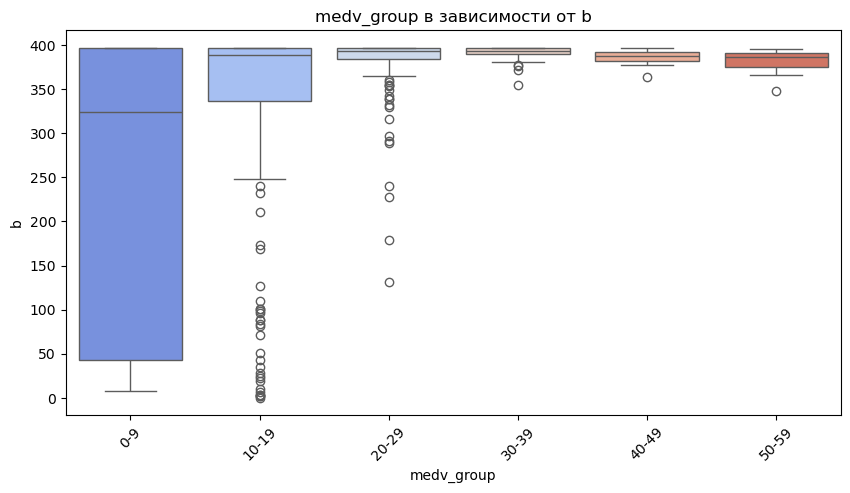

In [47]:
house.my_graf('medv_group', 'b')

### Вывод: Чернокожие жители предпочитают селиться в более дорогих домах, и чем дом дороде тем их кол-во статичнее. А вот самых дешевых домах живут все кто может и там кол-во людей может быть разное.

## Зависимость medv_group от dis

In [48]:
house.summary_statistics('medv_group', 'dis')

dis                                                          \
            count      mean       std     min       25%     50%       75%   
medv_group                                                                  
0-9          24.0  1.699088  0.177051  1.4254  1.560175  1.7291  1.821100   
10-19       186.0  3.062532  1.872051  1.1370  1.813675  2.3348  3.968925   
20-29       212.0  4.452888  2.014990  1.2852  2.848000  3.9454  5.720900   
30-39        53.0  4.934392  2.202569  1.8946  3.215700  4.5667  6.479800   
40-49        15.0  4.198000  1.917624  1.8773  2.883200  3.6519  5.164950   
50-59        16.0  2.586087  1.592896  1.1296  1.350650  2.0433  2.970600   

                     
                max  
medv_group           
0-9          2.0026  
10-19       10.7103  
20-29       10.7103  
30-39       12.1265  
40-49        8.9067  
50-59        5.8850

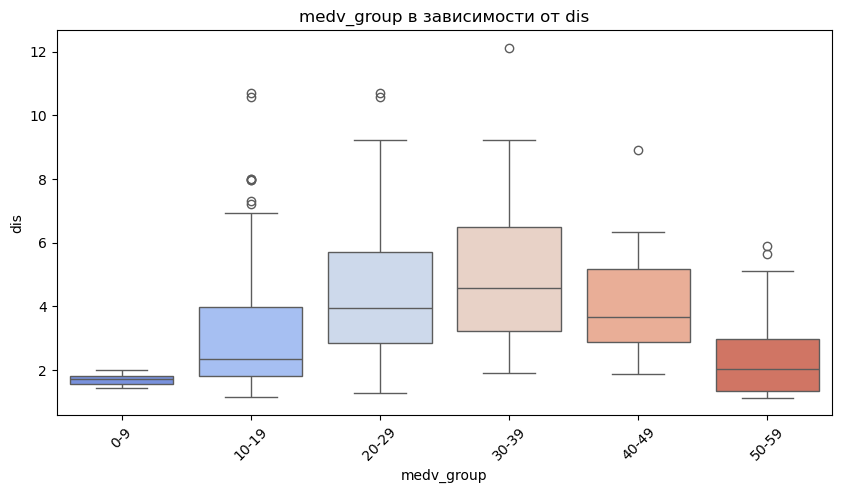

In [49]:
house.my_graf('medv_group', 'dis')

### Вывод: Мы наблюдаем рост растояния от центров занятости при ценах от 0 до 40. И затес спад с 40 до 59. 
- Гиппотеза: КАк мы уже отмечаели рост цены дома вызывается расположением дома в менее индустриальном, более спальном районе, для которых наличия центра занятости рядом -это сокрее минус. А более дорогие дома имеют зачастую специфичное расположение, в том числе и ярдом с бизнесцентрами/историческим частями города, поэтому расстояние снижается.